# -----------------------------------图像风格迁移-------------------------------------------------------

## 风格迁移：
- 风格迁移不同于以往的模型有固定的参数，每次输入的图像就是待更新的参数，所以风格迁移像是一次性的，来一张图像迁移一次，不能训练好模型后一直使用。另外，风格迁移也没有办法固定输入和标签，所以同样无法一次训练一直使用这种模式。

## 原理介绍：
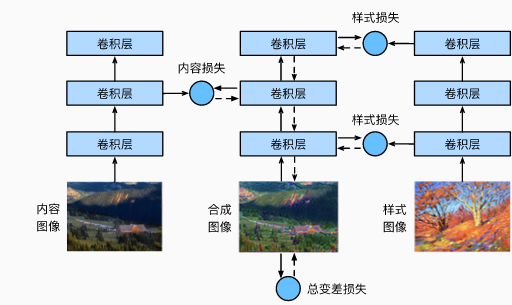
- 使用预训练的图像模型如VGG分别抽取原始图像和央视图像的特征，
- 使用什么来表示特征呢？
- 预训练模型中包含卷积层， 靠近输出端的几个卷积层可以用来表示图像的特征，一般靠近输出层的是内容特征，稍微远一点的是样式特征。
- 然后以原始图像作为输入，同样使用预训练的模型计算输出，根据输出卷积层于上面两个图像相同的层做损失，来更新参数，注意更新的是输入（也就是图像像素）不是抽取特征模型的参数。
- 一遍一遍的更新参数（也就是生成新的图像）来减少损失，最后达到满意的程度

In [1]:
import argparse
import numpy as np
from PIL import Image

import torch
import torchvision
import torch.nn as nn
from torchvision import models, transforms

In [3]:
"""定义使用GPU计算 """
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
"""定义加载图像的方法"""
def load_image(image_path, transform=None, max_size=None, shape=None):
    # 加载图像并将图像进行处理转化为tensor格式
    image = Image.open(image_path)
    
    # 对图像进行缩放处理
    if max_size:
        # 计算缩放尺寸
        scale = max_size / max(image.size)
        # 按缩放比例计算新的图像的大小
        size = np.array(image.size) * scale
        # 将图像缩放，并使用抗锯齿算法进行平滑处理
        image = image.resize(size.astype(int), Image.Resampling.LANCZOS)
    
    if shape:
        image = image.resize(shape, Image.Resampling.LANCZOS)
    
    if transform:
        # 对图像进行变形处理并转换到张量模式
        image = transform(image).unsqueeze(0)
    
    return image.to(device)

In [18]:
"""加载用于抽取图像特征的预训练图形模型VGG"""
class VGGNet(nn.Module):
    def __init__(self):
        # 选择1-5卷积层作为抽取内容和样式的层
        super(VGGNet, self).__init__()
        self.select = ['0', '5', '10', '19', '28']
        self.vgg = models.vgg19(pretrained=True).features
        
    def forward(self, x):
        # 提取多个卷积层的映射
        features = []
        # 遍历vgg中所有层和他们的名称
        for name, layer in self.vgg._modules.items():
            # 对每个层它都对输入进行处理，得到返回结果
            # 此处就是提取样式和内容特征
            x = layer(x)
            # 如果是选的层则储存下来
            if name in self.select:
                features.append(x)
            
        return features    

In [19]:
"""定义图像变形操作"""
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [28]:
"""加载原始图像和样式图像"""
content = load_image('png/content.png', transform, max_size=400)
style = load_image('png/style3.png', transform, shape=[content.size(2), content.size(3)])

In [29]:
"""对待合成的图形进行初始化"""
# 此处就是以原始图像为开始更新的起点，所有输入的像素就是待更新的参数
target = content.clone().requires_grad_(True)

In [30]:
"""定义损失函数和优化器"""
optimizer = torch.optim.Adam([target], lr=0.003, betas=[0.5, 0.999])
# 实例化模型
vgg = VGGNet().to(device).eval()

In [31]:
# 开始训练
for step in range(2000):
    # 每次遍历都会提取图像的风格和内容特征
    target_features = vgg(target)
    content_features = vgg(content)
    style_features = vgg(style)
    
    # 初始化损失
    style_loss = 0
    content_loss = 0
    
    # 
    for f1, f2, f3 in zip(target_features, content_features, style_features):
        # 计算内容损失
        content_loss += torch.mean((f1 - f2)**2)
        
        # 重塑卷积特征图
        _, c, h, w = f1.size()
        f1 = f1.view(c, h * w)
        f3 = f3.view(c, h * w)
        
        # 计算gram矩阵
        f1 = torch.mm(f1, f1.t())
        f3 = torch.mm(f3, f3.t())
        
        # 计算风格损失
        style_loss += torch.mean((f1 - f3)**2) / (c * h * w)
        
    # 合并内容损失和风格损失
    loss = content_loss + 100 * style_loss
    
    # 清零梯度并更新参数
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 打印进度
    if (step+1) % 10 == 0:
            print ('Step [{}/{}], Content Loss: {:.4f}, Style Loss: {:.4f}' 
                   .format(step+1, 2000, content_loss.item(), style_loss.item()))
            
    # 保存生成的图像
    if (step+1) % 500 == 0:
            # Save the generated image
            denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
            img = target.clone().squeeze()
            img = denorm(img).clamp_(0, 1)
            torchvision.utils.save_image(img, 'output-{}.png'.format(step+1))

Step [10/2000], Content Loss: 3.6245, Style Loss: 138.2392
Step [20/2000], Content Loss: 7.0070, Style Loss: 99.0772
Step [30/2000], Content Loss: 9.5424, Style Loss: 77.5195
Step [40/2000], Content Loss: 11.3627, Style Loss: 65.2989
Step [50/2000], Content Loss: 12.7167, Style Loss: 57.7520
Step [60/2000], Content Loss: 13.7175, Style Loss: 52.5915
Step [70/2000], Content Loss: 14.4703, Style Loss: 48.7003
Step [80/2000], Content Loss: 15.0731, Style Loss: 45.5593
Step [90/2000], Content Loss: 15.5749, Style Loss: 42.9279
Step [100/2000], Content Loss: 15.9976, Style Loss: 40.6667
Step [110/2000], Content Loss: 16.3646, Style Loss: 38.6851
Step [120/2000], Content Loss: 16.6961, Style Loss: 36.9233
Step [130/2000], Content Loss: 16.9906, Style Loss: 35.3470
Step [140/2000], Content Loss: 17.2545, Style Loss: 33.9274
Step [150/2000], Content Loss: 17.4961, Style Loss: 32.6392
Step [160/2000], Content Loss: 17.7213, Style Loss: 31.4624
Step [170/2000], Content Loss: 17.9306, Style Loss:

Step [1380/2000], Content Loss: 24.0829, Style Loss: 7.4957
Step [1390/2000], Content Loss: 24.0982, Style Loss: 7.4413
Step [1400/2000], Content Loss: 24.1133, Style Loss: 7.3875
Step [1410/2000], Content Loss: 24.1296, Style Loss: 7.3342
Step [1420/2000], Content Loss: 24.1465, Style Loss: 7.2813
Step [1430/2000], Content Loss: 24.1624, Style Loss: 7.2289
Step [1440/2000], Content Loss: 24.1782, Style Loss: 7.1770
Step [1450/2000], Content Loss: 24.1941, Style Loss: 7.1256
Step [1460/2000], Content Loss: 24.2107, Style Loss: 7.0747
Step [1470/2000], Content Loss: 24.2275, Style Loss: 7.0242
Step [1480/2000], Content Loss: 24.2442, Style Loss: 6.9743
Step [1490/2000], Content Loss: 24.2605, Style Loss: 6.9248
Step [1500/2000], Content Loss: 24.2766, Style Loss: 6.8758
Step [1510/2000], Content Loss: 24.2925, Style Loss: 6.8273
Step [1520/2000], Content Loss: 24.3085, Style Loss: 6.7793
Step [1530/2000], Content Loss: 24.3238, Style Loss: 6.7316
Step [1540/2000], Content Loss: 24.3398,